# Setup

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [3]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

# Loading Images

In [4]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


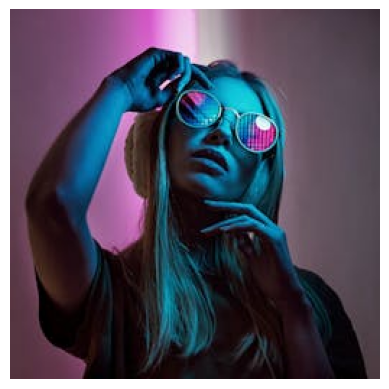

In [5]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [6]:
content_im.min(),content_im.max() # Check bounds

(tensor(0., device='mps:0'), tensor(1., device='mps:0'))

# Optimizing Images

In [7]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Train
                       DataLoader(LengthDataset(1), batch_size=1))      # Valid (length 1)

In [8]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

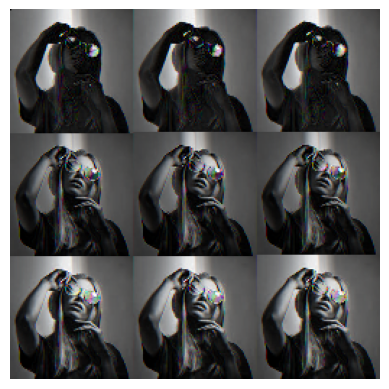

In [9]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [10]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

In [11]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

In [12]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

loss,epoch,train
0.082,0,train
0.082,0,eval


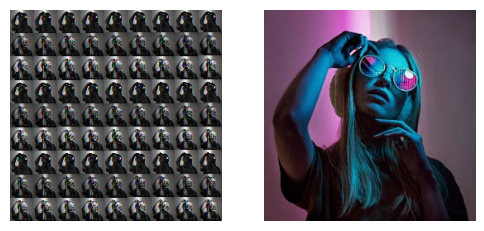

In [13]:
# Result (left) vs target image (right):
show_images([learn.model().clip(0, 1), content_im]);

## Viewing progress

It would be great if we could see what is happening over time. You could save individual images and turn them into a video, but for quick feedback we can also log images every few iterations and display them in a grid in `after_fit`:

In [14]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

loss,epoch,train
0.082,0,train
0.082,0,eval


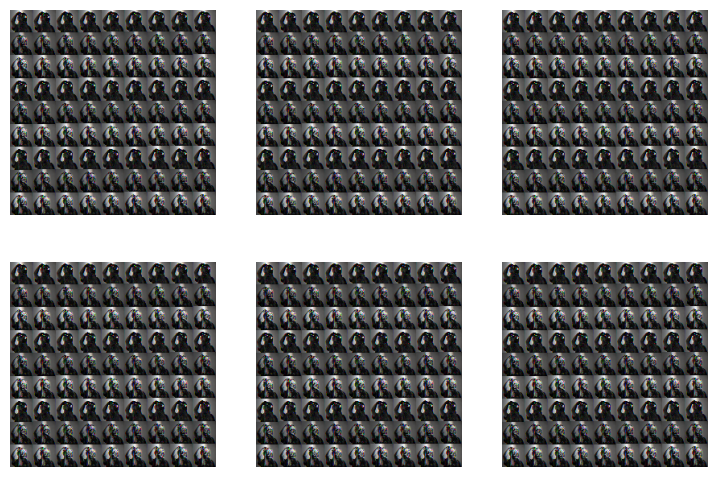

In [15]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

## Getting Features from VGG16

We're going to peek inside a small CNN and extract the outputs of different layers.

### Load VGG network

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [16]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [17]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [18]:
# vgg16

### Normalize Images

This model expacts images normalized with the same stats as those used during training, which in this case requires the stats of the ImageNet dataset. Previously we were working with single-channel images, and so normalizing was pretty straightforward. With three channels, we need to think a bit more about shapes and boradcasting rules:

In [19]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [20]:
# Try 1 (won't work):
# (content_im - imagenet_mean) / imagenet_std

In [21]:
imagenet_mean.shape

torch.Size([3])

In [22]:
content_im.shape

torch.Size([3, 256, 256])

In [23]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [24]:
# Try 2:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [25]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='mps:0'), tensor(2.6400, device='mps:0'))

In [26]:
normalize(content_im).mean(dim=(1, 2))

tensor([-0.9724, -0.9594, -0.4191], device='mps:0')

In [27]:
# And with torchvision transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [28]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='mps:0'), tensor(2.6400, device='mps:0'))

### Get intermediate representations, take 1:

We want to feed some data through the network, storing thr outputs of different layers. Here's one way to do this:

In [29]:
def calc_features(imgs, target_layers=(18, 25)): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [30]:
# Testing it out to see the shapes of the resulting feature maps:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

In [31]:
# Homework: Can you do this using hooks?

### What's the point?

You may remember us looking at https://distill.pub/2017/feature-visualization/ and talking about how deep CNNs 'learn' to classify images. Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature. We're going to exploit this hierarchy for artistic purposes, but being able to choose what kind of feature you'd like to use when comparing images has a number of other useful applications. 

# Optimizing an Image with Content Loss

To start with, let's try optimizing an image by comparing it's features (from two later layers) with those from the target image. If our theory is right, we should see the structure of the target emerge from the noise without necessarily seeing a perfect re-production of the target like we did in the previous MSE loss example.

In [32]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))

loss,epoch,train
781.449,0,train
781.449,0,eval


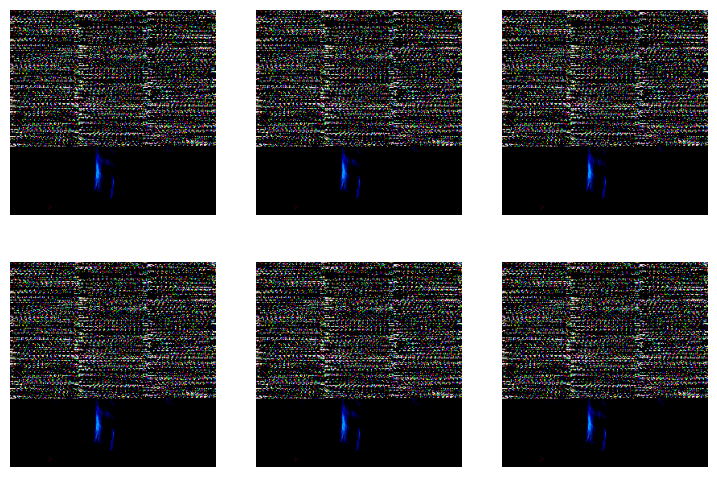

In [33]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

**Choosing the layers determines the kind of features that are important:**

loss,epoch,train
88.799,0,train
88.799,0,eval


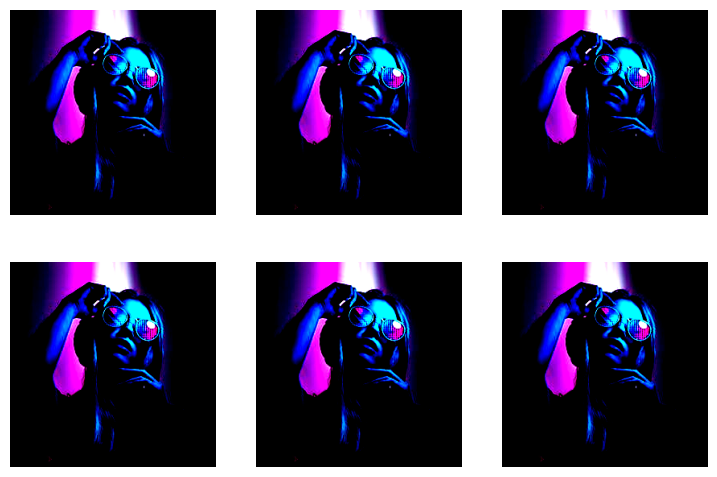

In [34]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=(1, 6))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

# Style Loss with Gram Matrix

So, we know how to extract feature maps. The next thing we'd like to do is find a way to capture the **style** of an input image, based on those early layers and the kinds of textural feature that they learn. Unfortunately, we can't just compare the feature maps from some early layers since these 'maps' encode information spatially - which we don't want!

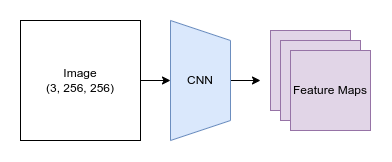

So, we need a way to measure what **kinds** of style features are present, and ideally which kinds occur together, without worrying about **where** these features occur in the image. 

Enter something called the Gram Matrix. The idea here is that we'll measure the **correlation** between features. Given a feature map with `f` features in an `h` x `w` grid, we'll flatten out the spatial component and then for every feature we'll take the dot product of that row with itself, giving an `f` x `f` matrix as the result. Each entry in this matrix quantifies how correlated the relevant pair of features are and how frequently they occur - exactly what we want. In this diagram each feature is represented as a colored dot.

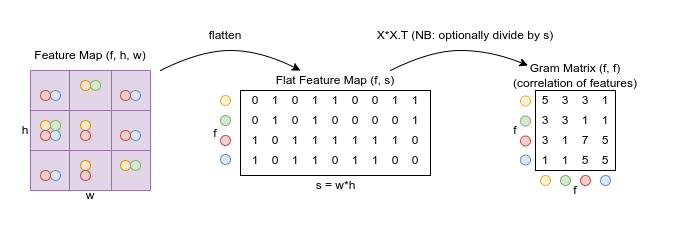

Re-creating the diagram operations in code:

In [35]:
t = tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
            [0, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0],
            [1, 0, 1, 1, 0, 1, 1, 0, 0]])

In [36]:
torch.einsum('fs, gs -> fg', t, t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [37]:
t.matmul(t.T) # Alternate approach

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

### Trying it out

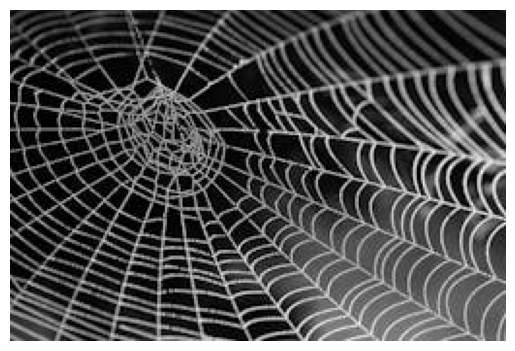

In [48]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);

In [39]:
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

In [40]:
style_grams = calc_grams(style_im)

In [41]:
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [42]:
style_grams.attrgot('shape') # The magic of fastcore's L

(#5) [torch.Size([64, 64]),torch.Size([128, 128]),torch.Size([256, 256]),torch.Size([512, 512]),torch.Size([512, 512])]

In [43]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [44]:
style_loss = StyleLossToTarget(style_im)

In [45]:
style_loss(content_im)

tensor(429.7879, device='mps:0', grad_fn=<AddBackward0>)

## Style Transfer

loss,epoch,train
429.788,0,train
429.788,0,eval


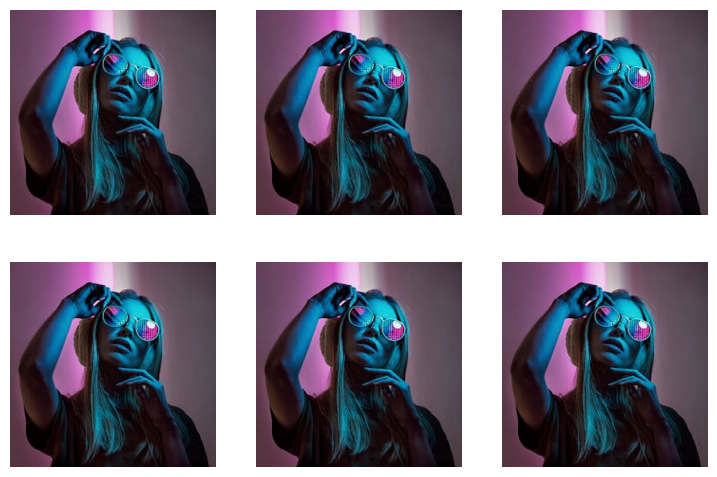

In [46]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

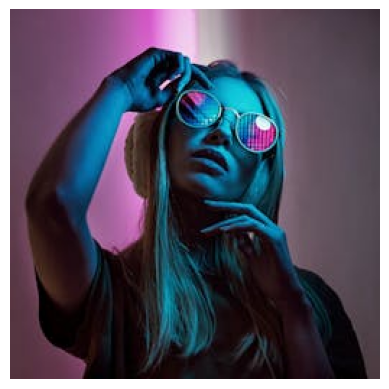

In [47]:
show_image(learn.model().clip(0, 1)); # View the final result

And trying with random starting image, weighting the style loss lower, using different layers:

loss,epoch,train
114.153,0,train
114.153,0,eval


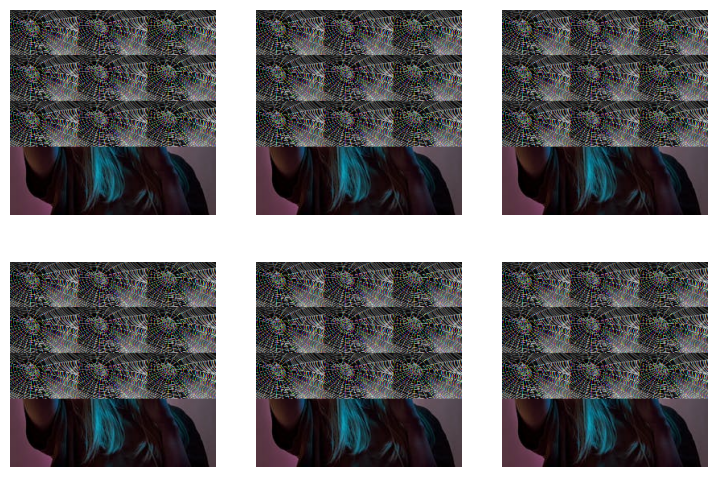

In [49]:
model = TensorModel(torch.rand_like(content_im))
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=(6, 18, 25))
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])

## For Comparison: non-miniai version

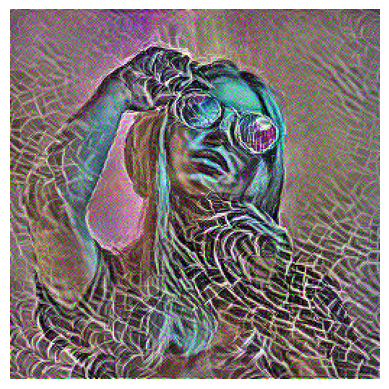

In [ ]:
# The image to be optimized
im = torch.rand(3, 256, 256).to(def_device)
im.requires_grad = True

# Set up the optimizer
opt = torch.optim.Adam([im], lr=5e-2)

# Define the loss function
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)

# Optimization loop
for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
# Show the result
show_image(im.clip(0, 1));

What do you think are some pros and cons? How would this look once we start displaying progress, testing different configurations and so on?